In [1]:
import numpy as np
import pandas as pd
from itertools import product
from sklearn import preprocessing
from itemrep_inference import topk_distance

In [2]:
data_path = '../data/logs_test_300421_1.p'

In [3]:
data = pd.read_pickle(data_path)
data.head()

,pk,created_at,client_ip,cookie_id,event_name,item_id,url
0,2021-04-30,2021-04-30 09:41:30.458,172.26.0.1,0:ko0sujvr:WcQ5Z8kIqvWRLp3~Rlpxu_ygeqqQMdkN,view,10008,http://127.0.0.1:8052/
1,2021-04-30,2021-04-30 09:41:30.597,172.26.0.1,0:ko0sujvr:WcQ5Z8kIqvWRLp3~Rlpxu_ygeqqQMdkN,view,10009,http://127.0.0.1:8052/
2,2021-04-30,2021-04-30 09:41:30.605,172.26.0.1,0:ko0sujvr:WcQ5Z8kIqvWRLp3~Rlpxu_ygeqqQMdkN,view,10001,http://127.0.0.1:8052/
3,2021-04-30,2021-04-30 09:41:30.616,172.26.0.1,0:ko0sujvr:WcQ5Z8kIqvWRLp3~Rlpxu_ygeqqQMdkN,view,10000,http://127.0.0.1:8052/
4,2021-04-30,2021-04-30 09:41:30.634,172.26.0.1,0:ko0sujvr:WcQ5Z8kIqvWRLp3~Rlpxu_ygeqqQMdkN,view,10002,http://127.0.0.1:8052/


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pk          215 non-null    object
 1   created_at  215 non-null    object
 2   client_ip   215 non-null    object
 3   cookie_id   215 non-null    object
 4   event_name  215 non-null    object
 5   item_id     215 non-null    int64 
 6   url         215 non-null    object
dtypes: int64(1), object(6)
memory usage: 11.9+ KB


In [5]:
data.describe(include='all')

,pk,created_at,client_ip,cookie_id,event_name,item_id,url
count,215,215,215,215,215,215.000000,215
unique,1,215,3,2,2,NaN,2
top,2021-04-30,2021-04-30 13:59:14.238,172.28.0.1,0:ko0sujvr:WcQ5Z8kIqvWRLp3~Rlpxu_ygeqqQMdkN,view,NaN,http://127.0.0.1:8052/
freq,215,1,122,179,160,NaN,119
mean,NaN,NaN,NaN,NaN,NaN,10004.623256,NaN
std,NaN,NaN,NaN,NaN,NaN,2.903819,NaN
min,NaN,NaN,NaN,NaN,NaN,10000.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,10002.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,10005.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,10007.000000,NaN


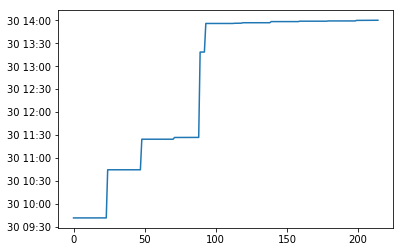

In [6]:
data.created_at = pd.to_datetime(data.created_at)
data.created_at.plot();

### Observations -> Actions
- zero variance in pk -> drop this variable
- during data collection, event was simulated on multiple timepoints, therefore this kind of step lines in time plot. We will focus on only last simulation -> select records happended after 13:30 on 30-apr-21
- client_id and cookie_id, both can be treated as user_identifier. Let's go with cookie_id -> drop client_ip
- map cookie_id to dash_basic_auth login profiles. this action is specific to this POC's MVP (minimum viable product) requirements
- remove view events - focus is only on click events
- drop url
- drop duplicates

In [7]:
def label_encoding(df, colname):
    le = preprocessing.LabelEncoder()
    le.fit(df[colname])
    le_mappings = dict(zip(le.classes_, le.transform(le.classes_)))
    return le_mappings

In [8]:
def preprocess(df):
    df = df.drop_duplicates()
    df = df[df.created_at > '2021-04-30 13:30:00']
    umap = {x:'user'+str(i) for i,x in enumerate(data.cookie_id.unique())}
    df = df.replace({"cookie_id": umap})
    user_mapping = label_encoding(df, 'cookie_id')
    item_mapping = label_encoding(df, 'item_id')
    df = df[df.event_name=='click']
    df.reset_index(drop=True, inplace=True)
    df = df[['cookie_id','item_id','created_at']]
    df.columns = ['userid','itemid','timestamp']
    return df, [user_mapping,item_mapping]

In [9]:
dataw, maps = preprocess(data)
dataw.head()

,userid,itemid,timestamp
0,user0,10005,2021-04-30 13:56:09.278
1,user0,10006,2021-04-30 13:56:10.916
2,user0,10005,2021-04-30 13:56:12.862
3,user0,10006,2021-04-30 13:56:13.956
4,user0,10006,2021-04-30 13:56:16.678


In [10]:
print('User Mappings: {}'.format(maps[0]))
print('Item Mappings: {}'.format(maps[1]))

User Mappings: {'user0': 0, 'user1': 1}
Item Mappings: {10000: 0, 10001: 1, 10002: 2, 10003: 3, 10004: 4, 10005: 5, 10006: 6, 10007: 7, 10008: 8, 10009: 9}


In [11]:
umap_inverse = {v: k for k, v in maps[0].items()}
imap_inverse = {v: k for k, v in maps[1].items()}

print('Inverse User Mappings: {}'.format(umap_inverse))
print('Inverse Item Mappings: {}'.format(imap_inverse))

Inverse User Mappings: {0: 'user0', 1: 'user1'}
Inverse Item Mappings: {0: 10000, 1: 10001, 2: 10002, 3: 10003, 4: 10004, 5: 10005, 6: 10006, 7: 10007, 8: 10008, 9: 10009}


In [12]:
dataw = dataw.replace({"userid": maps[0], "itemid": maps[1]})
dataw.head()

,userid,itemid,timestamp
0,0,5,2021-04-30 13:56:09.278
1,0,6,2021-04-30 13:56:10.916
2,0,5,2021-04-30 13:56:12.862
3,0,6,2021-04-30 13:56:13.956
4,0,6,2021-04-30 13:56:16.678


In [13]:
def create_pivot(df):
    df['count'] = 1
    schemadf = pd.DataFrame(list(product(list(maps[0].values()), list(maps[1].values()))), columns=['userid', 'itemid'])
    schemadf['count'] = 0
    df = df.append(schemadf)
    dfp = pd.pivot_table(df, values='count', index='userid',
                   columns='itemid', aggfunc=np.sum)
    dfp = dfp.fillna(0, downcast='infer')
    dfp = dfp.astype('int')
    return dfp

In [14]:
interactions = create_pivot(dataw)

In [15]:
interactions.style.background_gradient(cmap='Greens',high=interactions.max().max()/2)

itemid,0,1,2,3,4,5,6,7,8,9
userid,,,,,,,,,,
0,0,0,0,0,0,3,3,0,0,0
1,5,5,0,0,6,0,0,0,0,0


https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

In [16]:
def recommend(userid, topk=2):
    uid = maps[0][userid]
    _temp = interactions.iloc[uid]
    _temp = _temp[_temp!=0]
    _tempdf = pd.DataFrame(columns=['itemid','distance'])
    for row in _temp.iteritems():
        _temp1 = topk_distance(imap_inverse[row[0]])
        _temp2 = pd.DataFrame(list(_temp1.items()), columns=['itemid','distance'])
        _temp2['weight'] = row[1]
        _tempdf = _tempdf.append(_temp2)
    _tempdf = _tempdf[_tempdf['distance']!=0]
    _tempdf['distance']+=1
    _tempdf['score'] = np.sqrt(_tempdf['weight'])/np.log(_tempdf['distance'])
    _tempdf = _tempdf.set_index('itemid')
    _tempdf = _tempdf[['score']].groupby(['itemid']).mean()
    _tempdf = _tempdf.sort_values(by='score', ascending=False)
    return _tempdf.index.values[:topk]

In [17]:
recommend('user1')

array(['10003', '10002'], dtype=object)

In [18]:
import pickle
import os

artifact_path = 'artifacts'

pickle.dump(maps[0], open(os.path.join(artifact_path,"usermap.p"), "wb"))
pickle.dump(maps[1], open(os.path.join(artifact_path,"itemmap.p"), "wb"))
pickle.dump(umap_inverse, open(os.path.join(artifact_path,"usermap_inv.p"), "wb"))
pickle.dump(imap_inverse, open(os.path.join(artifact_path,"itemmap_inv.p"), "wb"))
pickle.dump(interactions, open(os.path.join(artifact_path,"interactions.p"), "wb"))